In [66]:
import pandas as pd
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import yaml
import fitsio
import numba as nb
from numba import jit
import fitsio as fio

import copy

from collections import OrderedDict

import xpipe.paths as paths
import xpipe.xhandle.parbins as parbins
import xpipe.xhandle.xwrap as xwrap
import xpipe.tools.selector as selector
import xpipe.xhandle.shearops as shearops
import matplotlib as mpl
# from matplotlib import rc
mpl.rc('font',**{'family':'serif','serif':['serif']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
# mpl.rcParams['figure.dpi'] = 300

# mpl.rcParams["font.family"] = "serif"
# mpl.rcParams["mathtext.fontset"] = "dejavuserif"
import astropy.constants as constants
import astropy.units as u
import astropy.cosmology as cosmology

import scipy.interpolate as interp

cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

from importlib import reload
%config InlineBackend.figure_format = 'svg'
import pickle

import xpipe.tools.y3_sompz as sompz

import xpipe.tools.selector as sl
import xpipe.tools.visual as visual
import xpipe.xhandle.pzboost as pzboost

import sklearn
import sklearn.covariance
import sklearn.neighbors
import sklearn.decomposition
import scipy.stats as stats

import NFW
import scipy.optimize as optimize
import emcee
from cluster_toolkit import deltasigma

from cluster_toolkit import xi
from cluster_toolkit import bias


from classy import Class
from multiprocessing import Pool

import corner
paths.update_params("/home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml")

updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb_meta.yml

***********************

running in full mode

***********************



# Prepare lens catalogs

col 0: ra

col 1: dec

col 6: w_sys

col 7: z

And you want to cut on col7 to get the 4 lens bins:
0.15-0.31
0.31-0.43
0.43-0.54
0.54-0.7 (edited) 

In [59]:
tmp = np.loadtxt("DESY3_CMASS.dat")[:, (0, 1, 6, 7)]
cmass = pd.DataFrame(data=tmp, columns=("RA", "DEC", "WSYS", "Z"))

oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_CMASS.fits"
tmp = cmass.to_records()
tmp["index"] = tmp["index"] + 1e6
fio.write(oname, cmass.to_records())

In [60]:
tmp = np.loadtxt("DESY3_LOWZ.dat")[:, (0, 1, 6, 7)]
lowz = pd.DataFrame(data=tmp, columns=("RA", "DEC", "WSYS", "Z"))

oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_LOWZ.fits"
fio.write(oname, lowz.to_records())

In [64]:
# tmp = cmass.to_records()

allgal = pd.concat((lowz, cmass), ignore_index=True)

oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL.fits"
fio.write(oname, allgal.to_records())

In [112]:
weights = pd.DataFrame()
weights["ww"] = allgal["WSYS"]
weights["id"] = np.arange(len(allgal))

# DeltaSigma

In [71]:
def sigma_crit_inv(zclust, z):
    global cosmo
    prefac = (4. * np.pi * constants.G / (constants.c**2.)).to(u.pc / u.Msun)
    
    Ds = cosmo.angular_diameter_distance(z).to(u.pc)
    Dl = cosmo.angular_diameter_distance(zclust).to(u.pc)
    Dls = cosmo.angular_diameter_distance_z1z2(zclust, z).to(u.pc)
    
    val = prefac * Dl * Dls / Ds
#     print(val)
    resval = np.max((0. , val.value))
    return resval

In [72]:
main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat_03_31_20.h5"
main_file = h5py.File(main_file_path, mode = 'r')
zlows = main_file["catalog/sompz/pzdata/zlow"][:]
zhighs = main_file["catalog/sompz/pzdata/zhigh"][:]
zcens = zlows + (zhighs - zlows) / 2.
zcens = zcens[:300]
# zedges = np.concatenate((zlows[:300],  [zhighs[299],]))

source_bins = [
    main_file["catalog/sompz/pzdata/bin0"][:],
    main_file["catalog/sompz/pzdata/bin1"][:],
    main_file["catalog/sompz/pzdata/bin2"][:],
    main_file["catalog/sompz/pzdata/bin3"][:],
]

# zclust_grid = np.linspace(0.05, 1., 101)
zclust_grid_edges = np.linspace(0.00, 1.0, 101)
zclust_grid = zclust_grid_edges[:-1] + np.diff(zclust_grid_edges) / 2.

In [73]:
scritinv_tab = np.zeros(shape=(len(zclust_grid), len(zcens)))
for i, zclust in enumerate(zclust_grid):
    if i%10==0:
        print(i)
    for j, zsource in enumerate(zcens):
        scritinv_tab[i,j] = sigma_crit_inv(zclust, zsource)

0


/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


10
20
30
40
50
60
70
80
90


In [74]:
def get_bin_scinv(clust_zvals, clust_zedges, scrit_tab, source_weight):
    ccounts = np.histogram(clust_zvals, bins=clust_zedges)[0]
    zcens = clust_zedges[:-1] + np.diff(clust_zedges) / 2.
    
    scvals = np.zeros(len(zcens))
    for i, z in enumerate(zcens):
#         print(i)
        scvals[i] = np.average(scrit_tab[i], weights=source_weight)
    
    scritinv = np.average(scvals, weights=ccounts)
    return scritinv
#         scvals.append(_scvals)
    
    

In [ ]:
"/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v01/lw"

In [139]:
flist, flist_jk, rlist, rlist_jk = parbins.get_file_lists(paths.params, paths.dirpaths)
# for i, clust_name in enumerate(flist_jk):
i = 0
profiles = []
for clust_name in flist_jk:
    _profiles = []
    for sbin in (1, 2, 3):
#         clust_name = flist_jk[i]
        print("processing source bin", sbin)
        clust_infos = xwrap.create_infodict(clust_name)
        clust_files = [info["outfile"].replace("_result.dat", "_bin" + str(sbin + 1) + "_result.dat") for info in clust_infos]
        clust = shearops.process_profile(clust_files, ismeta=False, weights=weights, shear=True)
        _profiles.append(clust)
    profiles.append(_profiles)    

processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3


In [140]:
# zcats = []
scinvs = []
for i in np.arange(4):
#     for j in np.arange(3):
#         print(i, j)
    _tmp = np.loadtxt("/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-" + str(i) + ".dat")
    lenscat = pd.DataFrame(_tmp, columns=("id", "ra", "dec", "z", "dummy"))
#         infocat = pd.DataFrame(profiles[i][j].info, columns=("id", "dummy1", "dummy1"))
#         _zcat = pd.merge(infocat, lenscat, on="id", how="left")
#         zcats.append(_zcat)
    _scinvs = []
    for sbin in source_bins:
#         print("")
        _scinvs.append(get_bin_scinv(lenscat["z"], zclust_grid_edges, scritinv_tab, sbin))
    scinvs.append(_scinvs)

In [141]:
scinvs

[[0.00010145401737101593,
  0.0001979503794049132,
  0.00027927937459365954,
  0.0003022193459432364],
 [4.740915081285735e-05,
  0.0001388915758420724,
  0.0002701118970196759,
  0.0003157856175262755],
 [2.1662942858382383e-05,
  7.536142602715516e-05,
  0.00020609369017543681,
  0.00027643223624244207],
 [1.3281843440956174e-05,
  4.216359219225781e-05,
  0.00013653914791820473,
  0.00022447867439065935]]

In [142]:
zbins = ((0.15, 0.31), (0.31, 0.43), (0.43, 0.54), (0.54, 0.7))

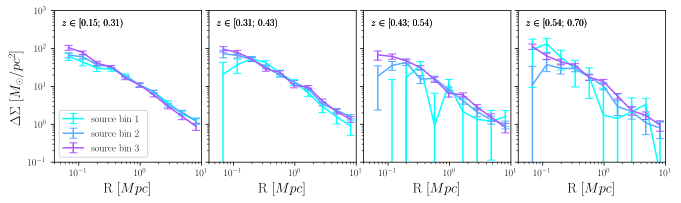

In [143]:
fig, axarr = plt.subplots(ncols=4, nrows=1, figsize=(11, 2.8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

colors = mpl.cm.cool(np.linspace(0, 1., 4))
fs = 14
for i in np.arange(4):
    axarr[i].set_xlabel("R [$Mpc$]", fontsize=fs)
    axarr[0].set_ylabel("$\Delta\Sigma$ [$M_\odot / pc^2$]", fontsize=fs)

    for s in np.arange(3):
        scinv = scinvs[i][s+1]
        prof = profiles[i][s]
            
        axarr[i].errorbar(prof.rr, prof.dst / scinv, yerr=prof.dst_err / scinv,
                             capsize=4, color=colors[s], label="source bin "+str(s+1))

#         axarr[i].text(0.65, 0.9, "$\lambda\in[{:d};\,{:d})$".format(*lbins[2-i]), transform=axarr[i,j].transAxes)
        axarr[i].text(0.05, 0.9, "$z\in[{:.2f};\,{:.2f})$".format(*zbins[i]), transform=axarr[i].transAxes)

#             axarr[2-i, j].set_xticklabels([])
        
#         axarr[i, 1].set_yticklabels([])
        
#         axarr[i, 2].set_yticklabels([])


        axarr[i].set_xscale("log")
        axarr[i].set_yscale("log")
        
        
        axarr[i].set_xscale("log")
#         axarr[i].axvline(0.2, color="black", ls="--")
#         axarr[i].text(0.3, 0.1, "Y1 cut", transform=axarr[i, j].transAxes, fontsize=14)
        
#         axarr[i].axvspan(0.0323, 0.5, color="lightgray")
        
axarr[0].set_xlim(0.04, 10.)              
axarr[0].set_ylim(0.1, 1000)        

# for i in np.arange(3):
#     axarr[i, 2].set_yticklabels([])    
#     axarr[i, 1].set_yticklabels([])    
axarr[0].legend(loc=3)       
fig.savefig("LWB_DeltaSigma_tomographic_bins_v01.pdf", bbox_inches="tight", dpi=300)
fig.savefig("LWB_DeltaSigma_tomographic_bins_v01.png", bbox_inches="tight", dpi=300)

In [173]:
tmp_profs = copy.deepcopy(profiles)
fnames = []
for i in np.arange(4):
    for s in np.arange(3):
        scinv = scinvs[i][s+1]
        prof = tmp_profs[i][s]
        prof.multiply(1 / scinv)
        fname = "LWB_lowz+cmass_noboost_raw_zbin"+str(i)+"_source-bin"+str(s+1)
        fnames.append(fname)
        write_profile(prof, fname)

saving: LWB_lowz+cmass_noboost_raw_zbin0_source-bin1_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin0_source-bin2_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin0_source-bin3_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin1_source-bin1_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin1_source-bin2_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin1_source-bin3_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin2_source-bin1_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin2_source-bin2_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin2_source-bin3_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin3_source-bin1_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin3_source-bin2_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin3_source-bin3_profile.dat


In [172]:
fnames

['LWB_lowz+cmass_noboost_raw_zbin0_source-bin1',
 'LWB_lowz+cmass_noboost_raw_zbin0_source-bin2',
 'LWB_lowz+cmass_noboost_raw_zbin0_source-bin3',
 'LWB_lowz+cmass_noboost_raw_zbin1_source-bin1',
 'LWB_lowz+cmass_noboost_raw_zbin1_source-bin2',
 'LWB_lowz+cmass_noboost_raw_zbin1_source-bin3',
 'LWB_lowz+cmass_noboost_raw_zbin2_source-bin1',
 'LWB_lowz+cmass_noboost_raw_zbin2_source-bin2',
 'LWB_lowz+cmass_noboost_raw_zbin2_source-bin3',
 'LWB_lowz+cmass_noboost_raw_zbin3_source-bin1',
 'LWB_lowz+cmass_noboost_raw_zbin3_source-bin2',
 'LWB_lowz+cmass_noboost_raw_zbin3_source-bin3']

In [ ]:
fnames = [
    "./SPT_qq_clusters_R",
    "./SPT_qq_clusters_E"
]

In [166]:
profiles[0][0].dst

array([0.01226019, 0.00871508, 0.00598132, 0.00561284, 0.00390022,
       0.00215421, 0.00140016, 0.00074328, 0.00038518, 0.00024288])

In [162]:
tmp.multiply(1. / scinvs[0][1])

0.0001979503794049132

In [145]:
# for i, clust_name in enumerate(flist_jk):
sprofiles = []
comb_profiles = []
for j, clust_name in enumerate(flist_jk):
    _profiles = []
    for i, sbin in enumerate((1, 2, 3)):
        print("processing source bin", sbin)
        clust_infos = xwrap.create_infodict(clust_name)
        clust_files = [info["outfile"].replace("_result.dat", "_bin" + str(sbin + 1) + "_result.dat") for info in clust_infos]
        clust = shearops.process_profile(clust_files, ismeta=False, weights=None, shear=True)
        _profiles.append(clust)  
    sprofiles.append(_profiles)
        
    prof1 = copy.deepcopy(_profiles[0])
    prof2 = copy.deepcopy(_profiles[1])
    prof3 = copy.deepcopy(_profiles[2])

    prof1.multiply(scinvs[j][1])
    prof2.multiply(scinvs[j][2])
    prof3.multiply(scinvs[j][3])

    prof1.composite(prof2, operation="+")
    prof1.composite(prof3, operation="+")

    factor = 1. / (scinvs[j][1]**2. + scinvs[j][2]**2. + scinvs[j][3]**2.)
    prof1.multiply(factor)   
    
    comb_profiles.append(prof1)   

processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3
processing source bin 1
processing source bin 2
processing source bin 3


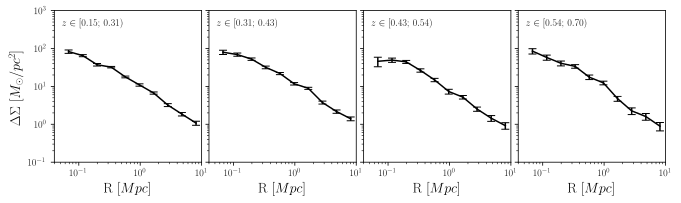

In [147]:
fig, axarr = plt.subplots(ncols=4, nrows=1, figsize=(11, 2.8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

colors = mpl.cm.cool(np.linspace(0, 1., 4))
fs = 14
for i in np.arange(4):
    axarr[i].set_xlabel("R [$Mpc$]", fontsize=fs)
    axarr[0].set_ylabel("$\Delta\Sigma$ [$M_\odot / pc^2$]", fontsize=fs)

#     for s in np.arange(3):
#         scinv = scinvs[i][s+1]
    prof = comb_profiles[i]
            
    axarr[i].errorbar(prof.rr, prof.dst, yerr=prof.dst_err, capsize=4, color="black")

#         axarr[i].text(0.65, 0.9, "$\lambda\in[{:d};\,{:d})$".format(*lbins[2-i]), transform=axarr[i,j].transAxes)
    axarr[i].text(0.05, 0.9, "$z\in[{:.2f};\,{:.2f})$".format(*zbins[i]), transform=axarr[i].transAxes)

#             axarr[2-i, j].set_xticklabels([])
        
#         axarr[i, 1].set_yticklabels([])
        
#         axarr[i, 2].set_yticklabels([])


    axarr[i].set_xscale("log")
    axarr[i].set_yscale("log")
        
        
    axarr[i].set_xscale("log")
#         axarr[i].axvline(0.2, color="black", ls="--")
#         axarr[i].text(0.3, 0.1, "Y1 cut", transform=axarr[i, j].transAxes, fontsize=14)
        
#         axarr[i].axvspan(0.0323, 0.5, color="lightgray")
        
axarr[0].set_xlim(0.04, 10.)              
axarr[0].set_ylim(0.1, 1000)        

# for i in np.arange(3):
#     axarr[i, 2].set_yticklabels([])    
#     axarr[i, 1].set_yticklabels([])    
# axarr[0].legend(loc=3)       
fig.savefig("LWB_DeltaSigma_tomographic_bins_v01-combine.pdf", bbox_inches="tight", dpi=300)
fig.savefig("LWB_DeltaSigma_tomographic_bins_v01-combine.png", bbox_inches="tight", dpi=300)

In [175]:
# tmp_profs = copy.deepcopy(profiles)
fnames = []
for i in np.arange(4):
#     for s in np.arange(3):
#         scinv = scinvs[i][s+1]
#         prof = tmp_profs[i][s]
#         prof.multiply(1 / scinv)
        fname = "LWB_lowz+cmass_noboost_raw_zbin"+str(i)+"_combined"
        fnames.append(fname)
        prof = comb_profiles[i]
        write_profile(prof, fname)

saving: LWB_lowz+cmass_noboost_raw_zbin0_combined_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin1_combined_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin2_combined_profile.dat
saving: LWB_lowz+cmass_noboost_raw_zbin3_combined_profile.dat


In [155]:
def write_profile(prof, path):
    """saves DeltaSigma and covariance in text format"""

    # Saving profile
    profheader = "R [Mpc]\tDeltaSigma_t [M_sun / pc^2]\tDeltaSigma_t_err [M_sun / pc^2]\tDeltaSigma_x [M_sun / pc^2]\tDeltaSigma_x_err [M_sun / pc^2]"
    res = np.vstack((prof.rr, prof.dst, prof.dst_err, prof.dsx, prof.dsx_err)).T
    fname = path + "_profile.dat"
    print("saving:", fname)
    np.savetxt(fname, res, header=profheader)

    # Saving covariance
    np.savetxt(path + "_dst_cov.dat", prof.dst_cov)
    np.savetxt(path + "_dsx_cov.dat", prof.dsx_cov)

# Calculating Boost factor

In [148]:
cid = main_file["catalog/bpz/unsheared/coadd_object_id"][:].byteswap().newbyteorder()
zmc = main_file["catalog/bpz/unsheared/zmc_sof"][:].byteswap().newbyteorder()
pz_chat = main_file["catalog/sompz/pzdata/pz_chat"][:]
bpz = pd.DataFrame()
bpz["ID"] = cid
bpz["ZMC"] = zmc

In [152]:
pair_datas = []
for j, clust_name in enumerate(flist_jk):
    _pair_datas = []
    print(j)
    for sbin in (1, 2, 3):
        print(j, sbin)
        clust_infos = xwrap.create_infodict(clust_name, pairs=True)
        tabs = []
        for i, tmp in  enumerate(clust_infos):
            print(j, sbin, i, end="\n")
            pair_name = tmp["outfile"].replace("_result.dat", "_bin" + str(sbin+1) + "_result_pairs.dat")
            try:
                tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])
            except:
                pass

        tabs = np.vstack(tabs)
        table = pd.DataFrame(tabs, columns=("MEM_MATCH_ID", "ID", "SOMCELL", "RBIN", "W"))
        match = pd.merge(table, bpz, how="left", on="ID")
        _pair_datas.append(match)
    pair_datas.append(_pair_datas)
#     break
pickle.dump(pair_datas, open("pair_datas_all.p", "wb"))

0
0 1
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 1 11
0 1 12
0 1 13
0 1 14
0 1 15
0 1 16
0 1 17
0 1 18
0 1 19
0 1 20
0 1 21
0 1 22
0 1 23
0 1 24
0 1 25
0 1 26
0 1 27


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-0_patch26_bin2_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


0 1 28
0 1 29
0 1 30
0 1 31
0 1 32
0 1 33
0 1 34
0 1 35
0 1 36
0 1 37
0 1 38
0 1 39
0 1 40
0 1 41
0 1 42
0 1 43
0 1 44
0 1 45
0 1 46
0 1 47
0 1 48
0 1 49
0 1 50
0 1 51
0 1 52
0 1 53
0 1 54
0 1 55
0 1 56
0 1 57
0 1 58
0 1 59
0 1 60
0 1 61
0 1 62
0 1 63
0 1 64
0 1 65
0 1 66
0 1 67
0 1 68
0 1 69
0 1 70
0 1 71
0 1 72
0 1 73
0 1 74
0 1 75
0 1 76
0 1 77
0 1 78
0 1 79
0 1 80
0 1 81
0 1 82
0 1 83
0 1 84
0 1 85
0 1 86
0 1 87
0 1 88
0 1 89
0 1 90
0 1 91
0 1 92
0 1 93
0 1 94
0 1 95
0 1 96
0 1 97
0 1 98
0 1 99
0 2
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 2 11
0 2 12
0 2 13
0 2 14
0 2 15
0 2 16
0 2 17
0 2 18
0 2 19
0 2 20
0 2 21
0 2 22
0 2 23
0 2 24
0 2 25
0 2 26
0 2 27


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-0_patch26_bin3_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


0 2 28
0 2 29
0 2 30
0 2 31
0 2 32
0 2 33
0 2 34
0 2 35
0 2 36
0 2 37
0 2 38
0 2 39
0 2 40
0 2 41
0 2 42
0 2 43
0 2 44
0 2 45
0 2 46
0 2 47
0 2 48
0 2 49
0 2 50
0 2 51
0 2 52
0 2 53
0 2 54
0 2 55
0 2 56
0 2 57
0 2 58
0 2 59
0 2 60
0 2 61
0 2 62
0 2 63
0 2 64
0 2 65
0 2 66
0 2 67
0 2 68
0 2 69
0 2 70
0 2 71
0 2 72
0 2 73
0 2 74
0 2 75
0 2 76
0 2 77
0 2 78
0 2 79
0 2 80
0 2 81
0 2 82
0 2 83
0 2 84
0 2 85
0 2 86
0 2 87
0 2 88
0 2 89
0 2 90
0 2 91
0 2 92
0 2 93
0 2 94
0 2 95
0 2 96
0 2 97
0 2 98
0 2 99
0 3
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 3 11
0 3 12
0 3 13
0 3 14
0 3 15
0 3 16
0 3 17
0 3 18
0 3 19
0 3 20
0 3 21
0 3 22
0 3 23
0 3 24
0 3 25
0 3 26
0 3 27


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-0_patch26_bin4_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


0 3 28
0 3 29
0 3 30
0 3 31
0 3 32
0 3 33
0 3 34
0 3 35
0 3 36
0 3 37
0 3 38
0 3 39
0 3 40
0 3 41
0 3 42
0 3 43
0 3 44
0 3 45
0 3 46
0 3 47
0 3 48
0 3 49
0 3 50
0 3 51
0 3 52
0 3 53
0 3 54
0 3 55
0 3 56
0 3 57
0 3 58
0 3 59
0 3 60
0 3 61
0 3 62
0 3 63
0 3 64
0 3 65
0 3 66
0 3 67
0 3 68
0 3 69
0 3 70
0 3 71
0 3 72
0 3 73
0 3 74
0 3 75
0 3 76
0 3 77
0 3 78
0 3 79
0 3 80
0 3 81
0 3 82
0 3 83
0 3 84
0 3 85
0 3 86
0 3 87
0 3 88
0 3 89
0 3 90
0 3 91
0 3 92
0 3 93
0 3 94
0 3 95
0 3 96
0 3 97
0 3 98
0 3 99
1
1 1
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
1 1 30
1 1 31
1 1 32
1 1 33
1 1 34
1 1 35


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-1_patch34_bin2_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


1 1 36
1 1 37
1 1 38
1 1 39
1 1 40
1 1 41
1 1 42
1 1 43
1 1 44
1 1 45
1 1 46
1 1 47
1 1 48
1 1 49
1 1 50
1 1 51
1 1 52
1 1 53
1 1 54
1 1 55
1 1 56
1 1 57
1 1 58
1 1 59
1 1 60
1 1 61
1 1 62
1 1 63
1 1 64
1 1 65
1 1 66
1 1 67
1 1 68
1 1 69
1 1 70
1 1 71
1 1 72
1 1 73
1 1 74
1 1 75
1 1 76
1 1 77
1 1 78
1 1 79
1 1 80
1 1 81
1 1 82
1 1 83
1 1 84
1 1 85
1 1 86
1 1 87
1 1 88
1 1 89
1 1 90
1 1 91
1 1 92
1 1 93
1 1 94
1 1 95
1 1 96
1 1 97
1 1 98
1 1 99
1 2
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 2 11
1 2 12
1 2 13
1 2 14
1 2 15
1 2 16
1 2 17
1 2 18
1 2 19
1 2 20
1 2 21
1 2 22
1 2 23
1 2 24
1 2 25
1 2 26
1 2 27
1 2 28
1 2 29
1 2 30
1 2 31
1 2 32
1 2 33
1 2 34
1 2 35


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-1_patch34_bin3_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


1 2 36
1 2 37
1 2 38
1 2 39
1 2 40
1 2 41
1 2 42
1 2 43
1 2 44
1 2 45
1 2 46
1 2 47
1 2 48
1 2 49
1 2 50
1 2 51
1 2 52
1 2 53
1 2 54
1 2 55
1 2 56
1 2 57
1 2 58
1 2 59
1 2 60
1 2 61
1 2 62
1 2 63
1 2 64
1 2 65
1 2 66
1 2 67
1 2 68
1 2 69
1 2 70
1 2 71
1 2 72
1 2 73
1 2 74
1 2 75
1 2 76
1 2 77
1 2 78
1 2 79
1 2 80
1 2 81
1 2 82
1 2 83
1 2 84
1 2 85
1 2 86
1 2 87
1 2 88
1 2 89
1 2 90
1 2 91
1 2 92
1 2 93
1 2 94
1 2 95
1 2 96
1 2 97
1 2 98
1 2 99
1 3
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 3 11
1 3 12
1 3 13
1 3 14
1 3 15
1 3 16
1 3 17
1 3 18
1 3 19
1 3 20
1 3 21
1 3 22
1 3 23
1 3 24
1 3 25
1 3 26
1 3 27
1 3 28
1 3 29
1 3 30
1 3 31
1 3 32
1 3 33
1 3 34
1 3 35


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-1_patch34_bin4_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


1 3 36
1 3 37
1 3 38
1 3 39
1 3 40
1 3 41
1 3 42
1 3 43
1 3 44
1 3 45
1 3 46
1 3 47
1 3 48
1 3 49
1 3 50
1 3 51
1 3 52
1 3 53
1 3 54
1 3 55
1 3 56
1 3 57
1 3 58
1 3 59
1 3 60
1 3 61
1 3 62
1 3 63
1 3 64
1 3 65
1 3 66
1 3 67
1 3 68
1 3 69
1 3 70
1 3 71
1 3 72
1 3 73
1 3 74
1 3 75
1 3 76
1 3 77
1 3 78
1 3 79
1 3 80
1 3 81
1 3 82
1 3 83
1 3 84
1 3 85
1 3 86
1 3 87
1 3 88
1 3 89
1 3 90
1 3 91
1 3 92
1 3 93
1 3 94
1 3 95
1 3 96
1 3 97
1 3 98
1 3 99
2
2 1
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27
2 1 28
2 1 29
2 1 30
2 1 31
2 1 32
2 1 33
2 1 34
2 1 35
2 1 36
2 1 37
2 1 38
2 1 39
2 1 40
2 1 41
2 1 42
2 1 43
2 1 44
2 1 45
2 1 46
2 1 47
2 1 48
2 1 49
2 1 50
2 1 51
2 1 52
2 1 53
2 1 54
2 1 55


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-2_patch54_bin2_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


2 1 56
2 1 57
2 1 58
2 1 59
2 1 60
2 1 61
2 1 62
2 1 63
2 1 64
2 1 65
2 1 66
2 1 67
2 1 68
2 1 69
2 1 70
2 1 71
2 1 72
2 1 73
2 1 74
2 1 75
2 1 76
2 1 77
2 1 78
2 1 79
2 1 80
2 1 81
2 1 82
2 1 83
2 1 84
2 1 85
2 1 86
2 1 87
2 1 88
2 1 89
2 1 90
2 1 91
2 1 92
2 1 93
2 1 94
2 1 95
2 1 96
2 1 97
2 1 98
2 1 99
2 2
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 2 11
2 2 12
2 2 13
2 2 14
2 2 15
2 2 16
2 2 17
2 2 18
2 2 19
2 2 20
2 2 21
2 2 22
2 2 23
2 2 24
2 2 25
2 2 26
2 2 27
2 2 28
2 2 29
2 2 30
2 2 31
2 2 32
2 2 33
2 2 34
2 2 35
2 2 36
2 2 37
2 2 38
2 2 39
2 2 40
2 2 41
2 2 42
2 2 43
2 2 44
2 2 45
2 2 46
2 2 47
2 2 48
2 2 49
2 2 50
2 2 51
2 2 52
2 2 53
2 2 54
2 2 55


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-2_patch54_bin3_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


2 2 56
2 2 57
2 2 58
2 2 59
2 2 60
2 2 61
2 2 62
2 2 63
2 2 64
2 2 65
2 2 66
2 2 67
2 2 68
2 2 69
2 2 70
2 2 71
2 2 72
2 2 73
2 2 74
2 2 75
2 2 76
2 2 77
2 2 78
2 2 79
2 2 80
2 2 81
2 2 82
2 2 83
2 2 84
2 2 85
2 2 86
2 2 87
2 2 88
2 2 89
2 2 90
2 2 91
2 2 92
2 2 93
2 2 94
2 2 95
2 2 96
2 2 97
2 2 98
2 2 99
2 3
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
2 3 8
2 3 9
2 3 10
2 3 11
2 3 12
2 3 13
2 3 14
2 3 15
2 3 16
2 3 17
2 3 18
2 3 19
2 3 20
2 3 21
2 3 22
2 3 23
2 3 24
2 3 25
2 3 26
2 3 27
2 3 28
2 3 29
2 3 30
2 3 31
2 3 32
2 3 33
2 3 34
2 3 35
2 3 36
2 3 37
2 3 38
2 3 39
2 3 40
2 3 41
2 3 42
2 3 43
2 3 44
2 3 45
2 3 46
2 3 47
2 3 48
2 3 49
2 3 50
2 3 51
2 3 52
2 3 53
2 3 54
2 3 55


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-2_patch54_bin4_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


2 3 56
2 3 57
2 3 58
2 3 59
2 3 60
2 3 61
2 3 62
2 3 63
2 3 64
2 3 65
2 3 66
2 3 67
2 3 68
2 3 69
2 3 70
2 3 71
2 3 72
2 3 73
2 3 74
2 3 75
2 3 76
2 3 77
2 3 78
2 3 79
2 3 80
2 3 81
2 3 82
2 3 83
2 3 84
2 3 85
2 3 86
2 3 87
2 3 88
2 3 89
2 3 90
2 3 91
2 3 92
2 3 93
2 3 94
2 3 95
2 3 96
2 3 97
2 3 98
2 3 99
3
3 1
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 1 15
3 1 16
3 1 17
3 1 18
3 1 19
3 1 20
3 1 21
3 1 22
3 1 23
3 1 24
3 1 25
3 1 26
3 1 27
3 1 28
3 1 29
3 1 30
3 1 31
3 1 32
3 1 33
3 1 34
3 1 35
3 1 36
3 1 37
3 1 38
3 1 39
3 1 40
3 1 41
3 1 42
3 1 43
3 1 44
3 1 45
3 1 46
3 1 47
3 1 48
3 1 49
3 1 50
3 1 51
3 1 52
3 1 53
3 1 54
3 1 55
3 1 56
3 1 57
3 1 58
3 1 59
3 1 60
3 1 61
3 1 62
3 1 63
3 1 64
3 1 65
3 1 66
3 1 67
3 1 68
3 1 69
3 1 70
3 1 71
3 1 72
3 1 73
3 1 74
3 1 75
3 1 76
3 1 77
3 1 78
3 1 79
3 1 80
3 1 81
3 1 82
3 1 83
3 1 84
3 1 85
3 1 86
3 1 87
3 1 88
3 1 89
3 1 90
3 1 91
3 1 92
3 1 93


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-3_patch92_bin2_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


3 1 94
3 1 95
3 1 96
3 1 97
3 1 98
3 1 99
3 2
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 2 5
3 2 6
3 2 7
3 2 8
3 2 9
3 2 10
3 2 11
3 2 12
3 2 13
3 2 14
3 2 15
3 2 16
3 2 17
3 2 18
3 2 19
3 2 20
3 2 21
3 2 22
3 2 23
3 2 24
3 2 25
3 2 26
3 2 27
3 2 28
3 2 29
3 2 30
3 2 31
3 2 32
3 2 33
3 2 34
3 2 35
3 2 36
3 2 37
3 2 38
3 2 39
3 2 40
3 2 41
3 2 42
3 2 43
3 2 44
3 2 45
3 2 46
3 2 47
3 2 48
3 2 49
3 2 50
3 2 51
3 2 52
3 2 53
3 2 54
3 2 55
3 2 56
3 2 57
3 2 58
3 2 59
3 2 60
3 2 61
3 2 62
3 2 63
3 2 64
3 2 65
3 2 66
3 2 67
3 2 68
3 2 69
3 2 70
3 2 71
3 2 72
3 2 73
3 2 74
3 2 75
3 2 76
3 2 77
3 2 78
3 2 79
3 2 80
3 2 81
3 2 82
3 2 83
3 2 84
3 2 85
3 2 86
3 2 87
3 2 88
3 2 89
3 2 90
3 2 91
3 2 92
3 2 93


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-3_patch92_bin3_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


3 2 94
3 2 95
3 2 96
3 2 97
3 2 98
3 2 99
3 3
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 3 8
3 3 9
3 3 10
3 3 11
3 3 12
3 3 13
3 3 14
3 3 15
3 3 16
3 3 17
3 3 18
3 3 19
3 3 20
3 3 21
3 3 22
3 3 23
3 3 24
3 3 25
3 3 26
3 3 27
3 3 28
3 3 29
3 3 30
3 3 31
3 3 32
3 3 33
3 3 34
3 3 35
3 3 36
3 3 37
3 3 38
3 3 39
3 3 40
3 3 41
3 3 42
3 3 43
3 3 44
3 3 45
3 3 46
3 3 47
3 3 48
3 3 49
3 3 50
3 3 51
3 3 52
3 3 53
3 3 54
3 3 55
3 3 56
3 3 57
3 3 58
3 3 59
3 3 60
3 3 61
3 3 62
3 3 63
3 3 64
3 3 65
3 3 66
3 3 67
3 3 68
3 3 69
3 3 70
3 3 71
3 3 72
3 3 73
3 3 74
3 3 75
3 3 76
3 3 77
3 3 78
3 3 79
3 3 80
3 3 81
3 3 82
3 3 83
3 3 84
3 3 85
3 3 86
3 3 87
3 3 88
3 3 89
3 3 90
3 3 91
3 3 92
3 3 93


<ipython-input-152-01eedc11c557>:13: UserWarning: loadtxt: Empty input file: "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_out/lwb-y3-lowz+cmass_v01/lwb-y3-lowz+cmass_v01_y1clust_qbin-3_patch92_bin4_result_pairs.dat"
  tabs.append(np.loadtxt(pair_name)[:, (0, 1, 2, 3, 4)])


3 3 94
3 3 95
3 3 96
3 3 97
3 3 98
3 3 99


In [154]:
! ls -lh pair_datas_all.p

-rw-r--r-- 1 vargatn users_db 3,4G 11. Mai 17:01 pair_datas_all.p
